# Part II - Observed Flight Delay Patterns 
## by Scott Kilgore

### Investigation Overview

**Overall Goals of the Presentation:**
- To explore the relationship between flight operational factors and the occurrence of delays.
- To identify specific patterns in delay times related to different days of the week, times of day, months, and flight distances.
- To provide actionable insights that can help in improving scheduling and operational efficiency.

**Key Insights:**
1. Delays are significantly more prevalent during night hours and on Thursdays and Fridays.
2. Seasonal peaks in delays occur during June and December, aligning with major vacation and holiday travel.
3. Longer flight distances tend to have fewer average departure delays, suggesting operational efficiencies in long-haul flights.

### Dataset Overview and Executive Summary

**Introduction to the Dataset:**
- The dataset comprises flight arrival and departure details for various airlines, capturing aspects such as flight dates, times, distances, and reported delays.
- Data spans various months and includes details for different days of the week and for flights covering a range of distances.

**Summary of Findings:**
- **Time-Based Delays:** Certain times of day and specific days of the week are more prone to delays, particularly evenings and end of the workweek days.
- **Seasonal Influences:** Delays peak during periods of high travel demand such as summer vacations and winter holidays.
- **Distance Correlation:** There is a negative correlation between the length of the flight distance and the frequency of departure delays.

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [2]:
# load in the dataset into a pandas dataframe
# Load the dataset
df = pd.read_csv('airline_2m.csv', encoding='latin1', low_memory=False)

## (Visualization 1)

**Visualization #1: Average Departure Delay by Day of Week, Time of Day**
- **Description:** This visualization illustrates that departure delays are most frequent at night and notably higher on Thursdays and Fridays.
- **Observations:** The pattern suggests that the end of the workweek, coupled with night hours, might strain airline operations, leading to more frequent delays.


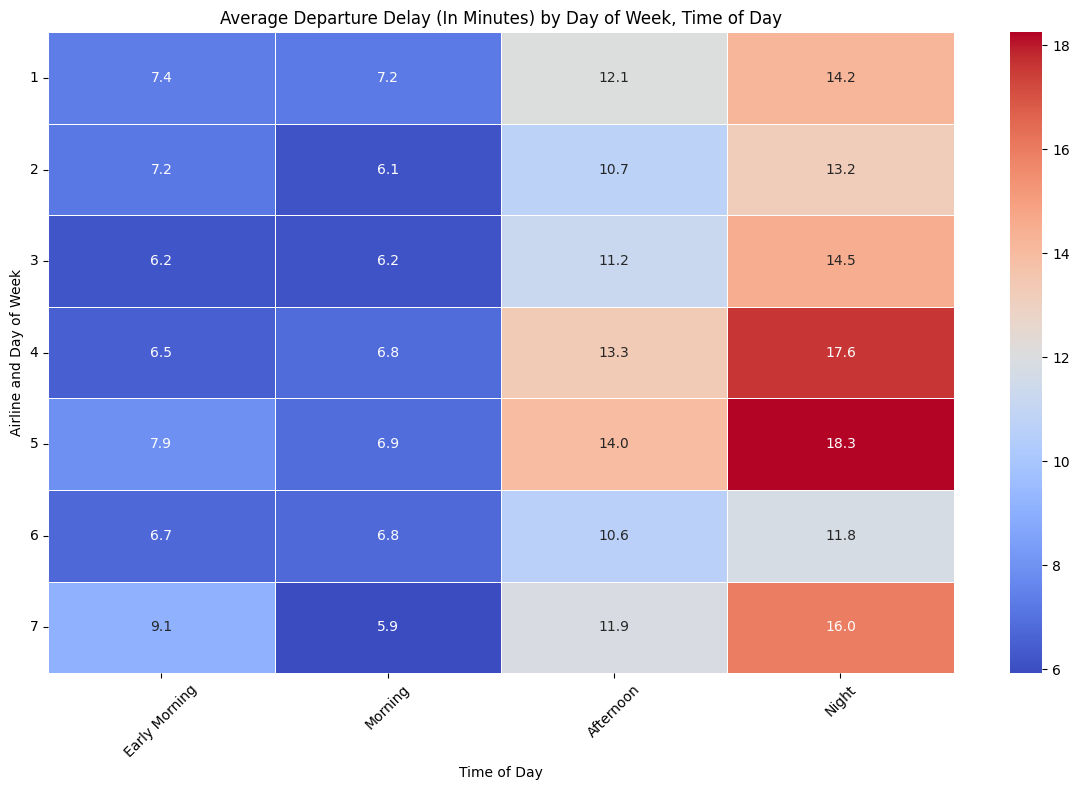

In [18]:

# Convert 'CRSDepTime' to hour blocks for easier visualization
df['CRSDepTimeBlock'] = pd.cut(df['CRSDepTime'], 
                               bins=[0, 600, 1200, 1800, 2400], 
                               labels=['Early Morning', 'Morning', 'Afternoon', 'Night'], 
                               right=False)

# Calculate average delay minutes for each combination of DayOfWeek and CRSDepTimeBlock
pivot_table = df.pivot_table(values='DepDelayMinutes', 
                             index=['DayOfWeek'], 
                             columns='CRSDepTimeBlock', 
                             aggfunc='mean')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, annot=True, cmap='coolwarm', fmt=".1f", linewidths=.5)
plt.title('Average Departure Delay (In Minutes) by Day of Week, Time of Day')
plt.xlabel('Time of Day')
plt.ylabel('Airline and Day of Week')
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


----

## (Visualization 2)

**Visualization #2: Average Arrival and Departure Delays by Month**
- **Description:** The chart highlights significant peaks in delay times during June and December, with notable mentions for July and August.
- **Observations:** These peaks align with major holiday seasons and summer vacations, indicating that increased travel volume during these months likely contributes to heightened delay occurrences.

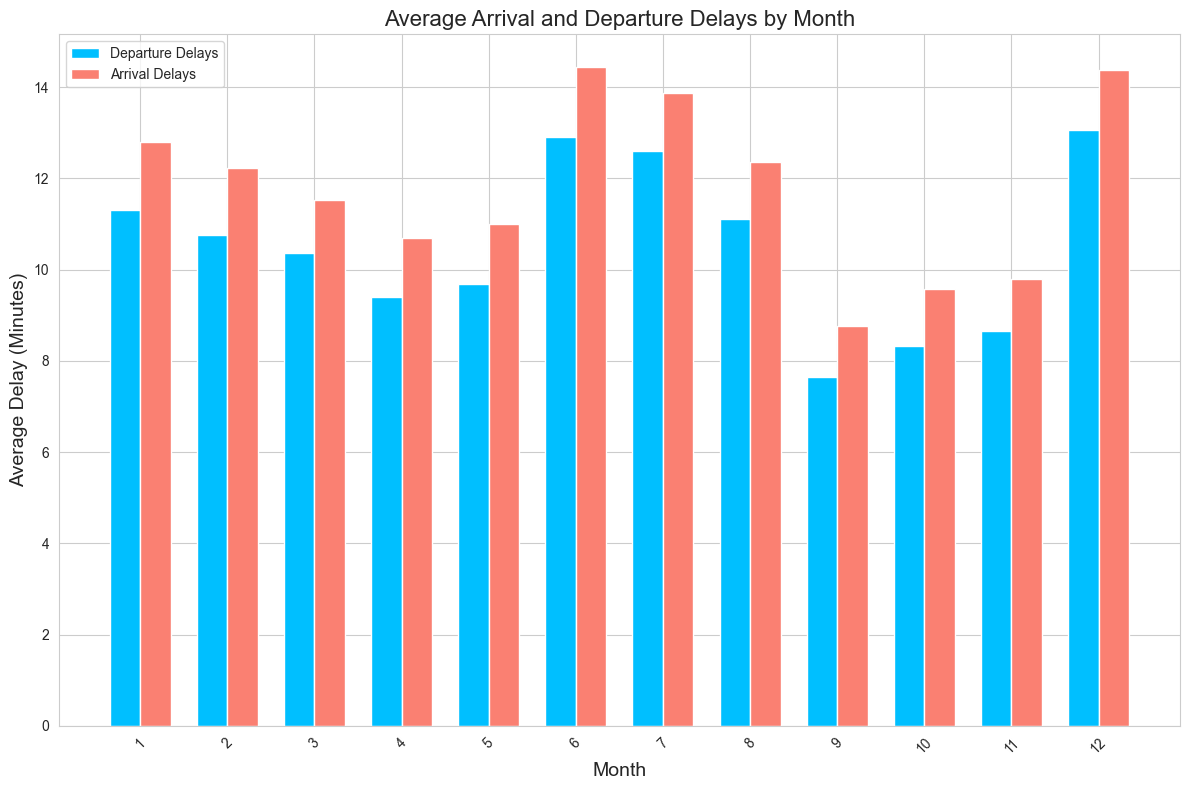

In [25]:
# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Calculate the average departure and arrival delays for each month
monthly_delays = df.groupby('Month').agg({
    'DepDelayMinutes': 'mean',
    'ArrDelayMinutes': 'mean'
}).reset_index()

# Create a figure and a set of subplots
fig, ax = plt.subplots(figsize=(12, 8))

# Calculate the width of the bars
bar_width = 0.35
index = monthly_delays['Month']

# Plotting both departure and arrival delays side by side
rects1 = ax.bar(index - bar_width/2, monthly_delays['DepDelayMinutes'], bar_width, label='Departure Delays', color='deepskyblue')
rects2 = ax.bar(index + bar_width/2, monthly_delays['ArrDelayMinutes'], bar_width, label='Arrival Delays', color='salmon')

# Add some text for labels, title, and axes ticks
ax.set_xlabel('Month', fontsize=14)
ax.set_ylabel('Average Delay (Minutes)', fontsize=14)
ax.set_title('Average Arrival and Departure Delays by Month', fontsize=16)
ax.set_xticks(index)
ax.set_xticklabels(monthly_delays['Month'])
ax.legend()


plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


----

## (Visualization 3)

**Visualization #3: Average Departures Delays vs. Flight Distance Categories**
- **Description:** This plot shows a clear trend where longer flights have less average departure delays compared to shorter ones.
- **Observations:** This insight could suggest that airlines are possibly more efficient in managing long-haul flights or that longer flights have more buffer built into their schedules to accommodate delays.

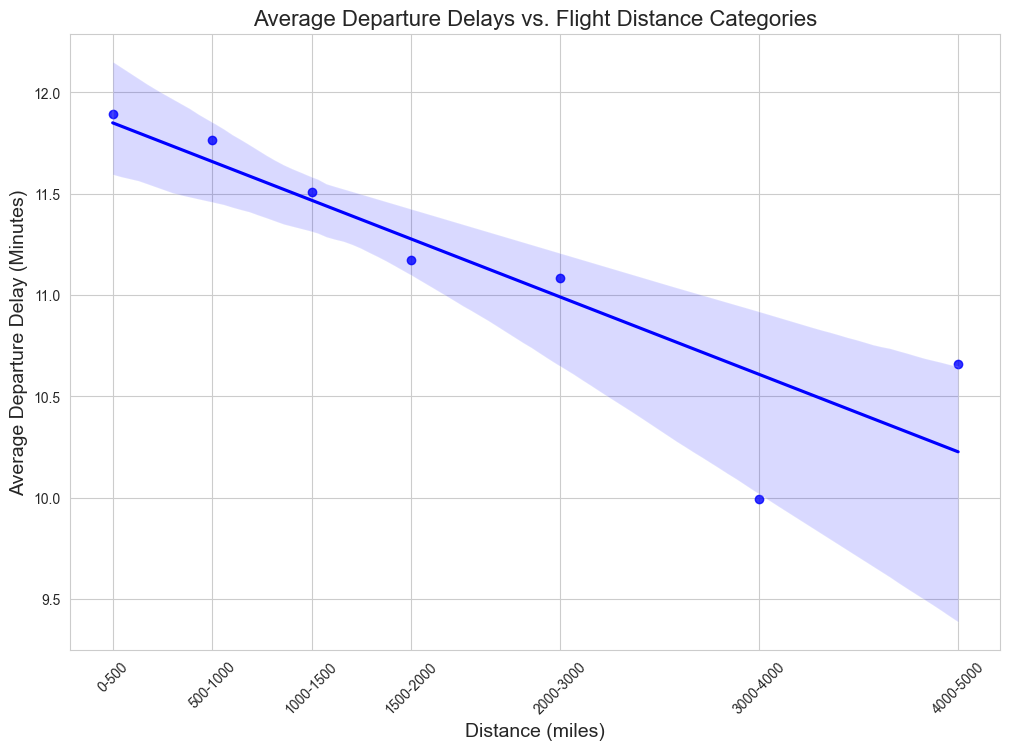

In [37]:
# Filter to ensure only positive delay times
df = df[df['DepDelayMinutes'] >= 0]

# Calculate IQR for DepDelayMinutes and remove outliers
Q1 = df['DepDelayMinutes'].quantile(0.25)
Q3 = df['DepDelayMinutes'].quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Remove outliers based on IQR criterion
df_filtered = df[(df['DepDelayMinutes'] >= lower_bound) & (df['DepDelayMinutes'] <= upper_bound)]

# Bin distances into categories
bins = [0, 500, 1000, 1500, 2000, 3000, 4000, 5000]
labels = [f'{int(b)}-{int(e)}' if e != float('inf') else f'{int(b)}+' for b, e in zip(bins[:-1], bins[1:])]
df_filtered['DistanceBin'] = pd.cut(df_filtered['Distance'], bins=bins, labels=labels)

# Calculate midpoints for visualization before grouping
mid_points = [bins[i] + (bins[i + 1] - bins[i]) / 2 for i in range(len(bins) - 1)]

# Calculate average delays for each distance bin
avg_delays = df_filtered.groupby('DistanceBin')['DepDelayMinutes'].mean().reset_index()

# Create a DataFrame for plotting that includes the mid_points
plot_data = pd.DataFrame({
    'MidPoint': mid_points,
    'AvgDelays': avg_delays['DepDelayMinutes']
})

# Scatter plot with regression line
plt.figure(figsize=(12, 8))
sns.regplot(x='MidPoint', y='AvgDelays', data=plot_data,
            scatter=True, fit_reg=True, marker='o', color='blue')
plt.title('Average Departure Delays vs. Flight Distance Categories', fontsize=16)
plt.xlabel('Distance (miles)', fontsize=14)
plt.ylabel('Average Departure Delay (Minutes)', fontsize=14)
plt.grid(True)
plt.xticks(ticks=mid_points, labels=labels, rotation=45)
plt.show()


----